<a href="https://colab.research.google.com/github/ViacheslavCRBP/pythonProject/blob/Rec_sistem_course/HW_PyTorch_07_Viacheslav_S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Домашнее задание к уроку 7

1. Попробуйте обучить нейронную сеть GRU/LSTM для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/LV1cYS1orMyRWA

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.model_selection import train_test_split

In [2]:
max_words = 2500
max_len = 25
num_classes = 1
epochs = 5
batch_size = 512
print_batch_n = 100

In [3]:
!pip install gdown

import gdown

def get_file_id(url):
    """
    Функция получает идентификатор файла на Google Диске из ссылки на файл.

    url: str, ссылка на файл на Google Диске

    returns: str, идентификатор файла на Google Диске
    """
    file_id = None
    try:
        # Извлекаем идентификатор файла из URL-адреса
        if 'drive.google.com' in url:
            file_id = url.split('/')[-2]
        elif 'docs.google.com' in url:
            file_id = url.split('/')[-1]
        else:
            raise ValueError('Некорректная ссылка на Google Диск.')

        # Удаляем лишние параметры из идентификатора файла
        if '?' in file_id:
            file_id = file_id.split('?')[0]
        if '&' in file_id:
            file_id = file_id.split('&')[0]

    except ValueError as e:
        print(f'Ошибка: {e}')

    return file_id

url = 'https://drive.google.com/file/d/1-A1_hc3mkm_bEOYxfTpYFxlvRlX6Ymf9/view?usp=share_link'
output_file = 'data.zip'
file_id = get_file_id(url)
gdown_url = f'https://drive.google.com/uc?export=download&id={file_id}'

if file_id:
    gdown.download(gdown_url, output_file, quiet=False)
else:
    print('Ошибка: некорректная ссылка на Google Диск.')


Downloading...
From: https://drive.google.com/uc?export=download&id=1-A1_hc3mkm_bEOYxfTpYFxlvRlX6Ymf9
To: /content/data.zip
100%|██████████| 1.96M/1.96M [00:00<00:00, 81.9MB/s]


In [4]:
!unzip -u data.zip

Archive:  data.zip
  inflating: test.csv                
  inflating: __MACOSX/._test.csv     
  inflating: train.csv               
  inflating: __MACOSX/._train.csv    


In [5]:
df = pd.read_csv("train.csv")
target_name = 'label'

"label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist"

In [6]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = pd.concat([df, sample])

    return df.sample(frac=1)

In [7]:
df_for_balancing = df
df_balanced = balance_df_by_target(df_for_balancing, target_name)
df_balanced[target_name].value_counts()

0    29720
1    29146
Name: label, dtype: int64

In [8]:
df_train, df_val = train_test_split(df_balanced, test_size=0.3, random_state=42) #shuffle=True, stratify=df['label'], )

In [9]:
!pip install stop-words pymorphy2

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 65.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32898 sha256=61622d9c6404f54abc9681eff1b20aafecaf81d3ea841367e9aa16a972b315d7
  Stored in directory: /root/.cache/pip/wheels/d0/1a/23/f12552a50cb09bcc1694a5ebb6c2cd5f2a0311de2b8c3d9a89
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=529b88d777d886e833a5478f0e759c5319580948e655bb8cc59afe0972f0ef57
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built stop-words docopt


In [10]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [11]:
sw = set(get_stop_words("en"))
new_sw = {'im', 'u', 'us', '2', '2016', '4', '2017', 'ive', '3', '1', 'r', 'iam', 's', 'n', '10', 'ur', 'w', '8', '5', 'd', 'shes', '7', 'b', 'ag', 'bc', '6', 'x', '12', 'gt', 'whos', '1st', 'self', '50', 't', 'y'}
sw = sw.union(new_sw)
puncts = set(punctuation)
puncts = puncts.union({'¦'})

In [12]:
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    # уберем все непечатные символы
    txt = re.sub(r'[^\x20-\x7E]', '', txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [13]:
from tqdm import tqdm
tqdm.pandas()

df_train['tweet'] = df_train['tweet'].progress_apply(preprocess_text)
df_val['tweet'] = df_val['tweet'].progress_apply(preprocess_text)

100%|██████████| 17660/17660 [00:06<00:00, 2592.12it/s]


In [14]:
train_corpus = " ".join(df_train["tweet"])
train_corpus = train_corpus.lower()

In [15]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")
tokens = word_tokenize(train_corpus)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [16]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [17]:
from nltk.probability import FreqDist

dist = FreqDist(tokens_filtered)
# берем max_words tokens минус 1 для padding
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [18]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}
len(vocabulary)

2499

In [19]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [20]:
%%time

x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["tweet"]])

CPU times: user 7.98 s, sys: 61 ms, total: 8.04 s
Wall time: 11.5 s


In [21]:
from torch.utils.data import DataLoader, Dataset
import torch

class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)

In [22]:
train_dataset = DataWrapper(x_train, df_train['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [23]:
val_dataset = DataWrapper(x_val, df_val['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [24]:
for x, l in train_loader:
    print(x.shape)
    print(l.shape)
    print(l[0])
    break

torch.Size([512, 25])
torch.Size([512])
tensor(0)


In [25]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device

'cuda'

### Сеть на GRU

In [26]:
from torch import nn

class GRUFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=2, batch_first=True, )
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        gru_out, ht = self.gru(x)

        if self.use_last:
            last_tensor = gru_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(gru_out[:,:], dim=1)

        out = self.linear(last_tensor)
        return torch.sigmoid(out)

In [27]:
gru_init = GRUFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(gru_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [28]:
print(gru_init)
print("Parameters:", sum([param.nelement() for param in gru_init.parameters()]))

GRUFixedLen(
  (embeddings): Embedding(2500, 128, padding_idx=0)
  (gru): GRU(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 331541


In [29]:
%%time

gru_init = gru_init.to(device)
gru_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):
    gru_init.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = gru_init(inputs)

        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()

    # выводим статистику о процессе обучения
    gru_init.eval()

    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
          f'Step [{i + 1}/{len(train_loader)}]. ' \
          f'Loss: {loss:.3f}. ' \
          f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = gru_init(data[0].to(device))

        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()

    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')

print('Training is finished!')

Epoch [1/5]. Step [81/81]. Loss: 0.436. Acc: 0.706. Test loss: 0.456. Test acc: 0.839
Epoch [2/5]. Step [81/81]. Loss: 0.303. Acc: 0.863. Test loss: 0.173. Test acc: 0.912
Epoch [3/5]. Step [81/81]. Loss: 0.253. Acc: 0.901. Test loss: 0.078. Test acc: 0.931
Epoch [4/5]. Step [81/81]. Loss: 0.182. Acc: 0.919. Test loss: 0.019. Test acc: 0.941
Epoch [5/5]. Step [81/81]. Loss: 0.192. Acc: 0.928. Test loss: 0.014. Test acc: 0.948
Training is finished!
CPU times: user 15.6 s, sys: 1.26 s, total: 16.8 s
Wall time: 23.6 s


После дополнительной очистки текста, балансировки классов и применения архитектуры GRU удалось улучшить accuracy на валидации до 94.4%.
Обучение заняло 22.3 секунды.

### Сеть на архитектуре LSTM

In [30]:
class LSTMFixedLen(nn.Module) :
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=128, use_last=True):
        super().__init__()
        self.use_last = use_last
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=2, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embeddings(x)
        x = self.dropout(x)
        lstm_out, ht = self.lstm(x)

        if self.use_last:
            last_tensor = lstm_out[:,-1,:]
        else:
            # use mean
            last_tensor = torch.mean(lstm_out[:,:], dim=1)

        out = self.linear(last_tensor)
        # print(out.shape)
        return torch.sigmoid(out)

In [31]:
lstm_init = LSTMFixedLen(max_words, 128, 20, use_last=False)
optimizer = torch.optim.Adam(lstm_init.parameters(), lr=0.001)
criterion = nn.BCELoss()

In [32]:
print(lstm_init)
print("Parameters:", sum([param.nelement() for param in lstm_init.parameters()]))

LSTMFixedLen(
  (embeddings): Embedding(2500, 128, padding_idx=0)
  (lstm): LSTM(128, 20, num_layers=2, batch_first=True)
  (linear): Linear(in_features=20, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)
Parameters: 335381


In [33]:
%%time

lstm_init = lstm_init.to(device)
lstm_init.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):
    lstm_init.train()
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()
        outputs = lstm_init(inputs)

        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()

    # выводим статистику о процессе обучения
    lstm_init.eval()

    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

    # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = lstm_init(data[0].to(device))

        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()

    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')

print('Training is finished!')

Epoch [1/5]. Step [81/81]. Loss: 0.490. Acc: 0.614. Test loss: 0.333. Test acc: 0.812
Epoch [2/5]. Step [81/81]. Loss: 0.365. Acc: 0.849. Test loss: 0.676. Test acc: 0.904
Epoch [3/5]. Step [81/81]. Loss: 0.217. Acc: 0.901. Test loss: 0.340. Test acc: 0.928
Epoch [4/5]. Step [81/81]. Loss: 0.236. Acc: 0.922. Test loss: 0.068. Test acc: 0.942
Epoch [5/5]. Step [81/81]. Loss: 0.141. Acc: 0.934. Test loss: 0.543. Test acc: 0.946
Training is finished!
CPU times: user 13.6 s, sys: 58.4 ms, total: 13.7 s
Wall time: 13.8 s


Обучение на архитектуре LSTM (Long Short-Term Memory) при несколько большем числе параметров (335381 у LSTM против 331541 в сети GRU) было почти в два раза быстрее и дало примерно такой же результат на валидации.

### Визуализируем архитектуру

In [34]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4133 sha256=3d16be5a259065832a7033c7dbb2ad1bd34b0bb81cc34eb0513285d5503a9a10
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


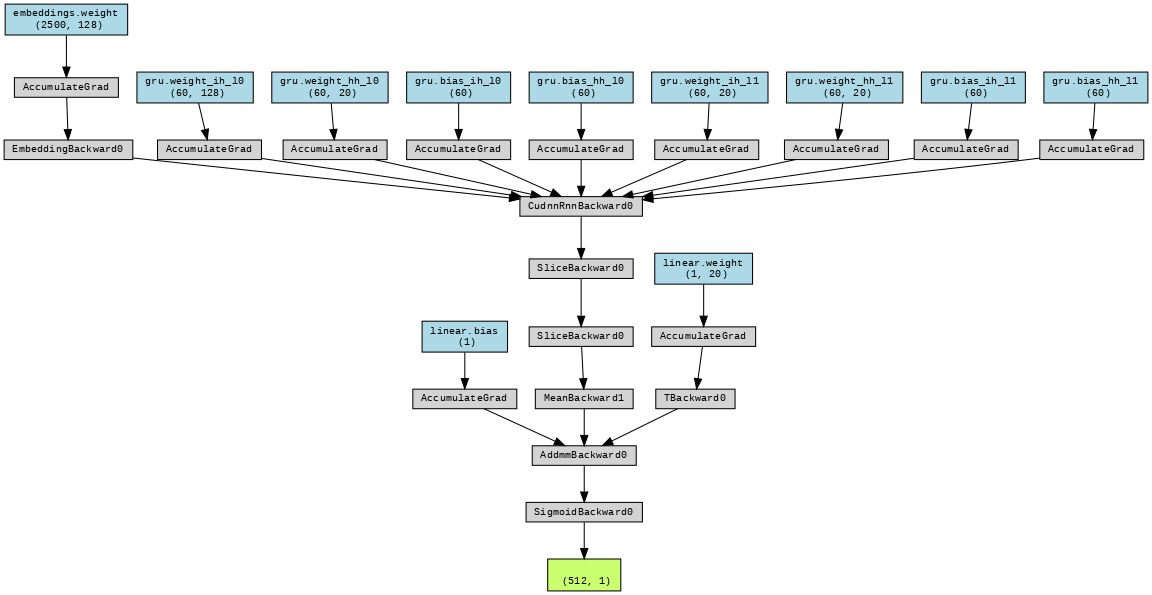

In [35]:
from torchviz import make_dot

# Создание фиктивных входных данных
x = torch.randint(low=0, high=2499, size=(batch_size, 25), dtype=torch.int)

# Создание графа вычислений
y = gru_init(x.to(device))
graph = make_dot(y, params=dict(gru_init.named_parameters()))

# Сохранение графа в файл
graph.format = 'png'
graph.render('gru_architecture', cleanup=True)

# Отображение файла с помощью функций Colab
from IPython.display import Image
Image('gru_architecture.png')

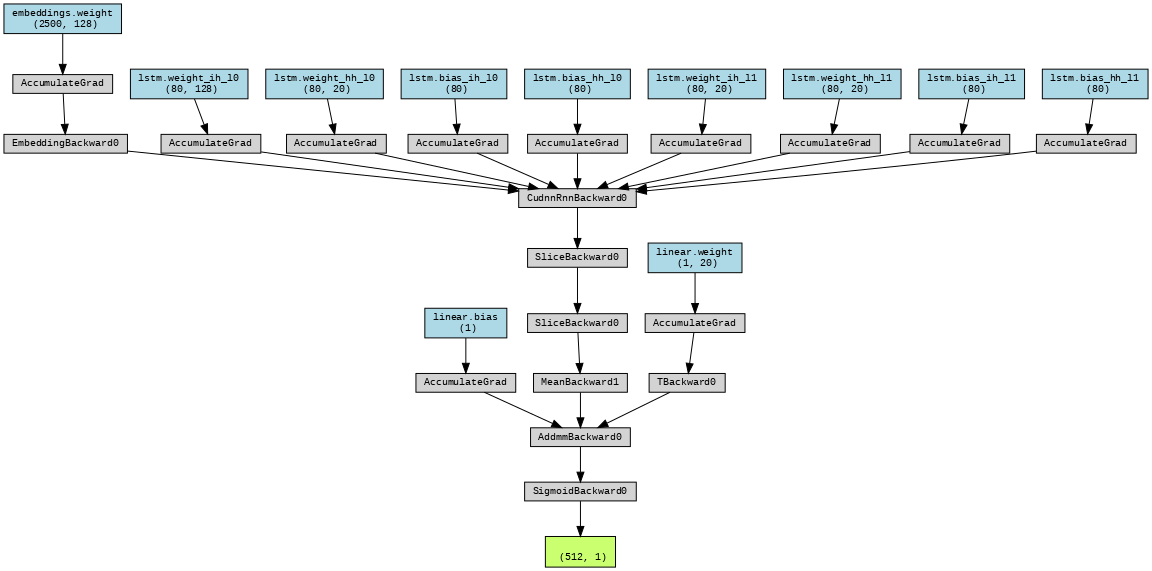

In [36]:
y = lstm_init(x.to(device))
graph = make_dot(y, params=dict(lstm_init.named_parameters()))

# Сохранение графа в файл
graph.format = 'png'
graph.render('lstm_architecture', cleanup=True)

# Отображение файла с помощью функций Colab
from IPython.display import Image
Image('lstm_architecture.png')

In [37]:
source_text = 'black dotted line shows accuracy and green one shows loss'

def predict(text, model):
  src = torch.tensor([text_to_sequence(preprocess_text(source_text), max_len)])
  return model(src.to(device)).item()

predict(source_text, lstm_init)

0.620436429977417

In [38]:
predict(source_text, gru_init)

0.18253590166568756